# 1. Import Libraries 

In [161]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import albumentations as A
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss


# 2. Check Pytorch Cuda Version 

In [162]:
print(torch.__version__)
print(torch.version.cuda)

2.4.1
None


In [163]:
import torch
print(torch.cuda.is_available())   # → False for a CPU-only build
print(torch.backends.mps.is_available())  # True on Apple-silicon if PyTorch ≥1.12


False
True


# 3. Dataset 

In [164]:
#!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

In [ ]:
file_path = "/Users/abdoulabdillahi/Desktop/2025/GenAI_AWS/Human-Segmentation/Human-Segmentation-Dataset-master/train.csv"

In [166]:
df = pd.read_csv(file_path)

In [167]:
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [168]:
df.shape

(290, 2)

# 4. Preparing Masks and Image for Visulaziation 

In [169]:
# def show_image(image,mask,pred_image = None):
    
#     if pred_image is None:
        
#         f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
#         ax1.set_title('IMAGE')
#         ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
#         ax2.set_title('GROUND TRUTH')
#         ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
#     elif pred_image is not None :
        
#         f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
#         ax1.set_title('IMAGE')
#         ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
#         ax2.set_title('GROUND TRUTH')
#         ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
#         ax3.set_title('MODEL OUTPUT')
#         ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

In [170]:
row = df.iloc[8]

In [171]:
row

masks     Human-Segmentation-Dataset-master/Ground_Truth...
images    Human-Segmentation-Dataset-master/Training_Ima...
Name: 8, dtype: object

In [172]:
image_path = row.images
mask_path = row.masks

In [173]:
image_path

'Human-Segmentation-Dataset-master/Training_Images/106.jpg'

In [174]:
mask_path

'Human-Segmentation-Dataset-master/Ground_Truth/106.png'

In [175]:
image = cv2.imread(image_path)

In [176]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [177]:
image.shape

(458, 307, 3)

In [178]:
# Convert the image to a tensor and normalize it
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) /255.0

## 6. Visualize the image and mask

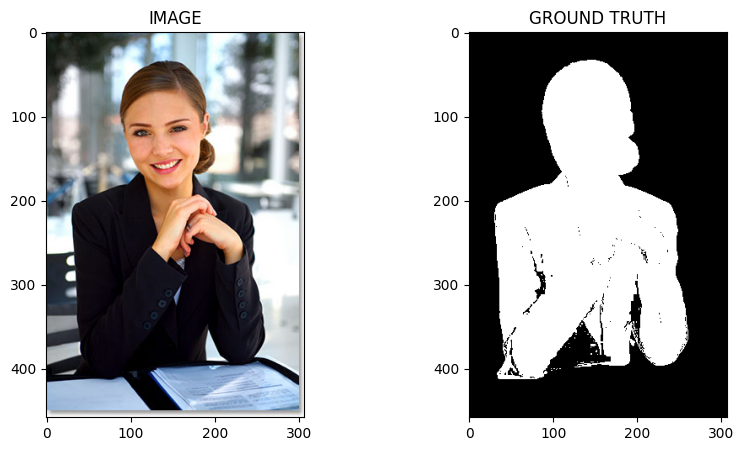

In [179]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask, cmap='gray')

### 7. Use Albumentation for data augmentation

In [180]:
from tkinter.tix import IMAGE


def get_train_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    ])

def get_valid_augs():
    return A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    ])

# 8. Prepare Our Custom Data 

In [181]:
class CustomDataset(Dataset):
    # constructor for the dataset
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)


        # Force resize both to IMAGE_SIZE to avoid mismatch
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        image = np.transpose(image, (2, 0, 1)).astype(np.float32)  # shape: (3, H, W)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)     # shape: (1, H, W)

        # Normalize the image and mask
        image = torch.Tensor(image) / 255.0
        mask = torch.Tensor(mask) / 255.0

        return image, mask


### Splitting Data into Train and Test

In [182]:
# For hyperparameter tuning, early stopping train_df, valid_df
IMAGE_SIZE = 256 #320
BATCH_SIZE = 16
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

In [183]:
len(train_df), len(valid_df)

(232, 58)

In [184]:
trainset = CustomDataset(train_df, augmentations=get_train_augs())
validset = CustomDataset(valid_df, augmentations=get_valid_augs())

In [185]:
print(f"Train set size: {len(trainset)}")
print(f"Validation set size: {len(validset)}")

Train set size: 232
Validation set size: 58


## Validation Trainset 

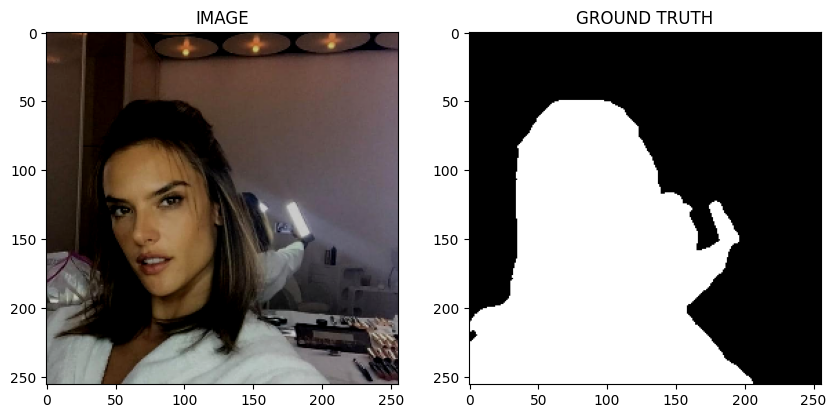

In [186]:
image, mask = trainset[1]  # Get the first image and mask from the training set

# Convert tensors to NumPy arrays and reshape
image_np = image.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
mask_np = mask.numpy().squeeze()            # (1, H, W) -> (H, W)

# Plotting
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title('IMAGE')
ax1.imshow(image_np)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask_np, cmap='gray')
plt.show()


# 11. Load the dataset into DataLoader

In [187]:
len(trainset), len(validset)

(232, 58)

In [188]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validaloader = DataLoader(validset, batch_size=BATCH_SIZE)


In [189]:
len(trainloader), len(validaloader)

(15, 4)

In [190]:
# check first batch of the dataloader
for images, masks in trainloader:
    print(f"Batch size: {images.shape}, Masks size: {masks.shape}")
    break

Batch size: torch.Size([16, 3, 256, 256]), Masks size: torch.Size([16, 1, 256, 256])


# 12 Building the model

In [ ]:
# This are the architecture parameters
ENCODER = 'timm-efficientnet-b0'
ENCODER_WEIGHTS = 'imagenet'

In [ ]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__() # 1️⃣: register model with PyTorch


        # 2️⃣ Define the architecture (U-Net here)
        self.arc = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=ENCODER_WEIGHTS,
            in_channels=3,
            classes=1,  # Binary segmentation
            activation=None  # Use sigmoid for binary segmentation
        )

# 4️⃣ Forward pass through the model
    def forward(self, images, masks = None):

        logits = self.arc(images)

        if masks is not None:
            loss1 = DiceLoss(mode='binary')(logits, masks) # commonly used for segmentation tasks (0,1)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2
        return logits  # 6️⃣ If no mask (inference), just return logits

### Why sum them?
1. Complementary signals
BCE teaches the network about every pixel; Dice teaches it to get the whole blob right.

2. Class-imbalance insurance
Dice counters BCE’s tendency to be dominated by easy background pixels.

3. Better convergence
Empirically the combo (sometimes called “BCE + Dice”) often reaches higher IoU and converges faster than either one alone.

In [198]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Initialize the model and move it to the appropriate device
model = SegmentationModel()
model.to(device)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /Users/abdoulabdillahi/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:02<00:00, 8.94MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

## 13. Prepare Train Function 

In [201]:
def train_function(data_loader, model, optimizer, device):

    model.train()  # set model to training mode
    total_loss = 0.0 

    # train loop 
    for images, masks in tqdm(data_loader, desc="Training"):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        logits, loss = model(images, masks)  # forward pass + loss computation
        loss.backward()  # backward pass to compute gradients
        optimizer.step()  # update weights

        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Training loss: {avg_loss:.4f}")
    return avg_loss 

## 14. Prepare Evaluation Function

In [ ]:
def eval_function(data_loader, model):
    model.eval()  # set model to evaluation mode
    total_loss = 0.0 # track total loss

    with torch.no_grad():  # no need to compute gradients during evaluation
        for images, masks in tqdm(data_loader, desc="Evaluating"):
            # move images and masks to the device
            images = images.to(device)
            masks = masks.to(device)

            logits, loss = model(images, masks)
            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Validation loss: {avg_loss:.4f}")
    return avg_loss

## 15.Define the Hyperparameters

In [ ]:

EPOCHS = 25 # number of times model will train on the entire dataset
LEARNING_RATE = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## 16. Train the Model and Save the Best Model

In [204]:
from pandas.core.algorithms import mode 
best_valid_loss = np.inf

for i in range(EPOCHS):

    train_loss = train_function(trainloader, model, optimizer, device)
    valid_loss = eval_function(validaloader, model)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved best model with validation loss: ", valid_loss)
        best_valid_loss = valid_loss

    print(f"Epoch : {i+1} Train Loss: {train_loss} Validation Loss: {valid_loss}")

Training: 100%|██████████| 15/15 [02:25<00:00,  9.69s/it]


Training loss: 0.8160


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.46s/it]


Validation loss: 0.9982
Saved best model with validation loss:  0.998164564371109
Epoch : 1 Train Loss: 0.8159721374511719 Validation Loss: 0.998164564371109


Training: 100%|██████████| 15/15 [02:16<00:00,  9.08s/it]


Training loss: 0.4946


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.34s/it]


Validation loss: 0.2997
Saved best model with validation loss:  0.29969311505556107
Epoch : 2 Train Loss: 0.4945718586444855 Validation Loss: 0.29969311505556107


Training: 100%|██████████| 15/15 [02:15<00:00,  9.06s/it]


Training loss: 0.4126


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


Validation loss: 0.3210
Epoch : 3 Train Loss: 0.41261228124300636 Validation Loss: 0.3210476338863373


Training: 100%|██████████| 15/15 [02:22<00:00,  9.53s/it]


Training loss: 0.3965


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.32s/it]


Validation loss: 0.3287
Epoch : 4 Train Loss: 0.3965088407198588 Validation Loss: 0.3287421241402626


Training: 100%|██████████| 15/15 [02:21<00:00,  9.42s/it]


Training loss: 0.3948


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.34s/it]


Validation loss: 0.2508
Saved best model with validation loss:  0.2508414015173912
Epoch : 5 Train Loss: 0.394814411799113 Validation Loss: 0.2508414015173912


Training: 100%|██████████| 15/15 [02:20<00:00,  9.36s/it]


Training loss: 0.3335


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


Validation loss: 0.2585
Epoch : 6 Train Loss: 0.33347339232762657 Validation Loss: 0.25850672274827957


Training: 100%|██████████| 15/15 [02:24<00:00,  9.66s/it]


Training loss: 0.3466


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


Validation loss: 0.2534
Epoch : 7 Train Loss: 0.34662752946217856 Validation Loss: 0.253427404910326


Training: 100%|██████████| 15/15 [02:24<00:00,  9.61s/it]


Training loss: 0.3307


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


Validation loss: 0.2889
Epoch : 8 Train Loss: 0.3307185669740041 Validation Loss: 0.28890620544552803


Training: 100%|██████████| 15/15 [02:20<00:00,  9.33s/it]


Training loss: 0.2815


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


Validation loss: 0.2807
Epoch : 9 Train Loss: 0.28151753346125286 Validation Loss: 0.2807399518787861


Training: 100%|██████████| 15/15 [02:19<00:00,  9.32s/it]


Training loss: 0.3344


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


Validation loss: 0.2790
Epoch : 10 Train Loss: 0.33440534869829813 Validation Loss: 0.2790166102349758


Training: 100%|██████████| 15/15 [02:28<00:00,  9.88s/it]


Training loss: 0.3116


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


Validation loss: 0.2676
Epoch : 11 Train Loss: 0.31162698566913605 Validation Loss: 0.2675647512078285


Training: 100%|██████████| 15/15 [02:29<00:00,  9.95s/it]


Training loss: 0.2808


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.37s/it]


Validation loss: 0.2248
Saved best model with validation loss:  0.22483006119728088
Epoch : 12 Train Loss: 0.2808235744635264 Validation Loss: 0.22483006119728088


Training: 100%|██████████| 15/15 [02:47<00:00, 11.15s/it]


Training loss: 0.2755


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.47s/it]


Validation loss: 0.2140
Saved best model with validation loss:  0.21399607509374619
Epoch : 13 Train Loss: 0.2754818230867386 Validation Loss: 0.21399607509374619


Training: 100%|██████████| 15/15 [02:27<00:00,  9.83s/it]


Training loss: 0.2432


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


Validation loss: 0.1979
Saved best model with validation loss:  0.19790174439549446
Epoch : 14 Train Loss: 0.2431520144144694 Validation Loss: 0.19790174439549446


Training: 100%|██████████| 15/15 [02:22<00:00,  9.48s/it]


Training loss: 0.2391


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


Validation loss: 0.1902
Saved best model with validation loss:  0.19016941264271736
Epoch : 15 Train Loss: 0.2390718311071396 Validation Loss: 0.19016941264271736


Training: 100%|██████████| 15/15 [02:27<00:00,  9.86s/it]


Training loss: 0.2471


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


Validation loss: 0.1809
Saved best model with validation loss:  0.18085022643208504
Epoch : 16 Train Loss: 0.24713258941968283 Validation Loss: 0.18085022643208504


Training: 100%|██████████| 15/15 [02:27<00:00,  9.80s/it]


Training loss: 0.3031


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.35s/it]


Validation loss: 0.1939
Epoch : 17 Train Loss: 0.30306429763635 Validation Loss: 0.19385423883795738


Training: 100%|██████████| 15/15 [02:20<00:00,  9.36s/it]


Training loss: 0.2538


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


Validation loss: 0.2434
Epoch : 18 Train Loss: 0.2538262983163198 Validation Loss: 0.24342771619558334


Training: 100%|██████████| 15/15 [02:24<00:00,  9.65s/it]


Training loss: 0.2640


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


Validation loss: 0.2442
Epoch : 19 Train Loss: 0.2640386333068212 Validation Loss: 0.2442060261964798


Training: 100%|██████████| 15/15 [02:25<00:00,  9.72s/it]


Training loss: 0.2791


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.38s/it]


Validation loss: 0.2570
Epoch : 20 Train Loss: 0.2790782610575358 Validation Loss: 0.25699111074209213


Training: 100%|██████████| 15/15 [02:25<00:00,  9.70s/it]


Training loss: 0.2457


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.39s/it]


Validation loss: 0.2113
Epoch : 21 Train Loss: 0.2457110106945038 Validation Loss: 0.21126801893115044


Training: 100%|██████████| 15/15 [02:24<00:00,  9.66s/it]


Training loss: 0.2519


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.36s/it]


Validation loss: 0.2797
Epoch : 22 Train Loss: 0.2518589824438095 Validation Loss: 0.2797062247991562


Training: 100%|██████████| 15/15 [02:23<00:00,  9.58s/it]


Training loss: 0.2204


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.33s/it]


Validation loss: 0.1873
Epoch : 23 Train Loss: 0.22037002245585124 Validation Loss: 0.18729973584413528


Training: 100%|██████████| 15/15 [02:22<00:00,  9.53s/it]


Training loss: 0.2014


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.41s/it]


Validation loss: 0.1891
Epoch : 24 Train Loss: 0.20137322694063187 Validation Loss: 0.18907557800412178


Training: 100%|██████████| 15/15 [02:28<00:00,  9.92s/it]


Training loss: 0.2381


Evaluating: 100%|██████████| 4/4 [00:09<00:00,  2.35s/it]

Validation loss: 0.1917
Epoch : 25 Train Loss: 0.2380999227364858 Validation Loss: 0.19165997952222824


## 17. Perform Predictions

In [ ]:
# Testing index 50 
idx = 50 

model.load_state_dict(torch.load('/Users/abdoulabdillahi/Desktop/2025/GenAI_AWS/Human-Segmentation/best_model.pth'))
image, mask = validset[idx]  # Get the image and mask from the validation set

logists_mask = model(image.unsqueeze(0).to(device))  # Add batch dimension and move to device
pred_mask = torch.sigmoid(logists_mask).squeeze().cpu().detach().numpy()  # Apply sigmoid and convert to numpy
pred_mask = (pred_mask > 0.5) * 1.0 # apply thresholding to get binary mask

/var/folders/lc/n5fml4jd4019lskc2ndx44jh0000gn/T/ipykernel_62559/743077674.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/Users/abdou

Predicted mask shape: (256, 256)


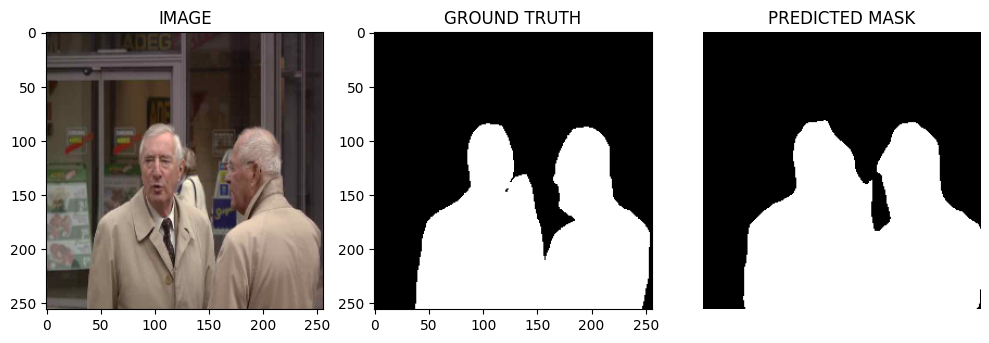

In [217]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

ax1.set_title('IMAGE')
ax1.imshow(image.permute(1,2,0))

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask.permute(1,2,0), cmap='gray')

# -- Predicted mask: already 2-D after threshold
ax3.set_title('PREDICTED MASK')
ax3.imshow(pred_mask, cmap='gray')
ax3.axis('off')
print(f"Predicted mask shape: {pred_mask.shape}")

plt.tight_layout()
plt.show()

           